In [47]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb

from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import make_pipeline 
from sklearn.feature_selection import SelectKBest,f_classif, mutual_info_classif, chi2

from sklearn.model_selection import train_test_split,learning_curve,GridSearchCV,RandomizedSearchCV
from sklearn.metrics import f1_score, confusion_matrix, classification_report,precision_recall_curve

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

pd.set_option('display.max_row', 100)
pd.set_option('display.max_column', 100)

%pwd

'C:\\Users\\pierr\\REPERTOIRE_PROJETS_DATA\\COVID_PROJECT'

In [14]:
data=pd.read_excel('dataset.xlsx')
df=data.copy()
df.dtypes.value_counts()

float64    70
object     37
int64       4
dtype: int64

# See the EDA file for cleaning justifications.

In [15]:
index_columns_to_keep=df.columns[df.isna().sum()/df.shape[0] <0.9]
df=df[index_columns_to_keep]


In [16]:
df=df.drop('Patient ID',axis=1)
df=df.drop('Influenza A, rapid test',axis=1) 
df=df.drop('Influenza B, rapid test',axis=1)
df=df.drop('Parainfluenza 2',axis=1)

df.shape

(5644, 35)

# Creating train and test

In [17]:
train, test=train_test_split(df,test_size=0.2,random_state=0)
train['SARS-Cov-2 exam result'].value_counts()


negative    4068
positive     447
Name: SARS-Cov-2 exam result, dtype: int64

In [18]:
test['SARS-Cov-2 exam result'].value_counts()

negative    1018
positive     111
Name: SARS-Cov-2 exam result, dtype: int64

# Preprocessing :
(dictionnary +  map function -> coding the status columns)

In [19]:
def encodage(df):
    code = {'negative':0, 
            'positive':1,
            'not_detected':2,
            'detected':3}
    
    for col in df.select_dtypes('object').columns:
        df.loc[:,col] = df[col].map(code)
    return df

def feature_engineering(df):
    # aborted tries (hospit status) irrelevant results
    return df

def imputation(df):
    df = df.dropna(axis=0) # raw drop but works!
    #df=df.fillna(0) 0 or -99, mean, ... not working
    return  df

def preprocessing(df):
    
    df = encodage(df)
    df = feature_engineering(df)
    df = imputation(df)
    
    X = df.drop('SARS-Cov-2 exam result', axis=1)
    y = df['SARS-Cov-2 exam result']
    
    print(y.value_counts())
    
    return X, y


In [20]:
X_train, y_train = preprocessing(train)


0    258
1     38
Name: SARS-Cov-2 exam result, dtype: int64


C:\Users\pierr\anaconda3\lib\site-packages\pandas\core\indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


In [21]:
X_test, y_test = preprocessing(test)

0    54
1    12
Name: SARS-Cov-2 exam result, dtype: int64


C:\Users\pierr\anaconda3\lib\site-packages\pandas\core\indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


# Evaluation function with learning curves :

In [22]:
def evaluation(model):
    model.fit(X_train,y_train)
    ypred=model.predict(X_test)
    
    print('score f1', f1_score(y_test,ypred))
    print(confusion_matrix(y_test,ypred))
    print(classification_report(y_test,ypred))
    
    N, train_score, val_score = learning_curve( model, X_train, y_train, cv=4,scoring='f1', train_sizes=np.linspace(0.1,1,10))
    #gives the f1 score every 10% of the dataset
    plt.figure()
    plt.plot(N,train_score.mean(axis=1), label='train')
    plt.plot(N,val_score.mean(axis=1),label='test')
    plt.legend()
    


# First simple modele : decision tree .

score f1 0.2727272727272727
[[47  7]
 [ 9  3]]
              precision    recall  f1-score   support

           0       0.84      0.87      0.85        54
           1       0.30      0.25      0.27        12

    accuracy                           0.76        66
   macro avg       0.57      0.56      0.56        66
weighted avg       0.74      0.76      0.75        66



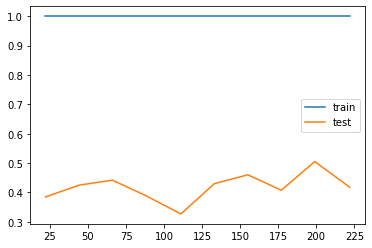

In [23]:
tree=DecisionTreeClassifier(random_state=0)# cp not optimized

evaluation(tree)

<AxesSubplot:>

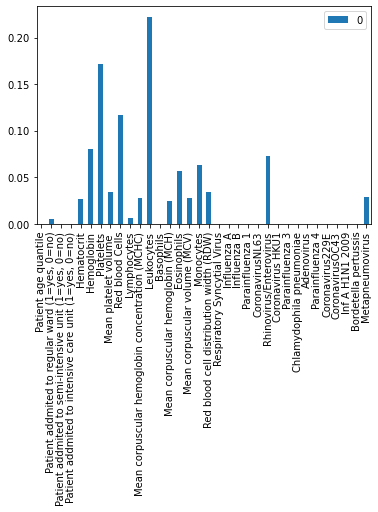

In [24]:
pd.DataFrame(tree.feature_importances_, index=X_train.columns).plot.bar()

# Second try : regularized modele. Random forest


score f1 0.2857142857142857
[[54  0]
 [10  2]]
              precision    recall  f1-score   support

           0       0.84      1.00      0.92        54
           1       1.00      0.17      0.29        12

    accuracy                           0.85        66
   macro avg       0.92      0.58      0.60        66
weighted avg       0.87      0.85      0.80        66



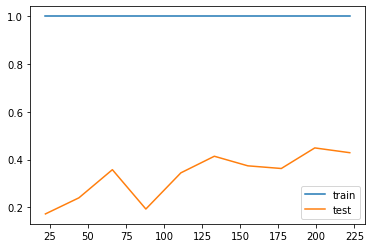

In [25]:
forest=RandomForestClassifier(random_state=0)

evaluation(forest)

# Quick improvement : forest + pipeline with k_best.

(best : f1=0.5)

C:\Users\pierr\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:114: UserWarning: Features [21 26 32] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
C:\Users\pierr\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


score f1 0.5
[[54  0]
 [ 8  4]]
              precision    recall  f1-score   support

           0       0.87      1.00      0.93        54
           1       1.00      0.33      0.50        12

    accuracy                           0.88        66
   macro avg       0.94      0.67      0.72        66
weighted avg       0.89      0.88      0.85        66



C:\Users\pierr\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:114: UserWarning: Features [ 3 18 19 21 24 25 26 27 28 29 30 31 32 33] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
C:\Users\pierr\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\pierr\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:114: UserWarning: Features [19 21 24 26 27 28 29 32 33] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
C:\Users\pierr\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\pierr\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:114: UserWarning: Features [19 21 26 28 32 33] are constant.
  warnings.warn("Fea

C:\Users\pierr\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:114: UserWarning: Features [21 22 24 25 26 27 28 29 30 32 33] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
C:\Users\pierr\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\pierr\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:114: UserWarning: Features [21 24 25 26 27 28 29 30 32] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
C:\Users\pierr\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\pierr\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:114: UserWarning: Features [21 24 25 26 27 28 29 30 32] are constant.
  warnings.warn("Fea

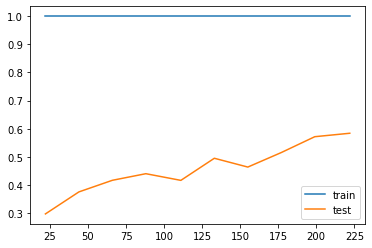

In [50]:
model_1=make_pipeline(SelectKBest(f_classif, k=10),RandomForestClassifier(random_state=0)) #fisher error with quali features

evaluation (model_1)

C:\Users\pierr\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:114: UserWarning: Features [21 26 32] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
C:\Users\pierr\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\pierr\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:114: UserWarning: Features [ 3 18 19 21 24 25 26 27 28 29 30 31 32 33] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
C:\Users\pierr\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\pierr\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:114: UserWarning: Features [19 21 24 26 27 28 29 32 33] are constant.
  warnings.warn("Features %s 

score f1 0.4761904761904762
[[50  4]
 [ 7  5]]
              precision    recall  f1-score   support

           0       0.88      0.93      0.90        54
           1       0.56      0.42      0.48        12

    accuracy                           0.83        66
   macro avg       0.72      0.67      0.69        66
weighted avg       0.82      0.83      0.82        66



C:\Users\pierr\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:114: UserWarning: Features [21 26 32] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
C:\Users\pierr\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\pierr\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:114: UserWarning: Features [21 26 32] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
C:\Users\pierr\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\pierr\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:114: UserWarning: Features [21 26 32] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
C:\Users\pi

C:\Users\pierr\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:114: UserWarning: Features [21 26 28 32] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
C:\Users\pierr\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\pierr\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:114: UserWarning: Features [ 3 21 22 24 25 26 27 28 29 30 32 33] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
C:\Users\pierr\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\pierr\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:114: UserWarning: Features [21 22 24 25 26 27 28 29 30 32 33] are constant.
  warnings.warn("Features 

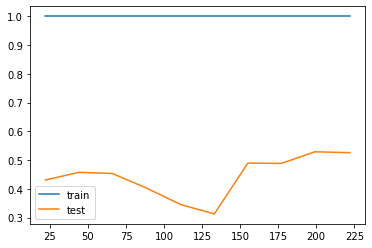

In [54]:
model_2=make_pipeline(SelectKBest(f_classif,k=10),DecisionTreeClassifier(random_state=0))
evaluation (model_2)

# ( Polynomial expansion. Should not work as it is already overfitting.)
But verification for learning purposes

C:\Users\pierr\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:114: UserWarning: Features [  0  22  27  33  70  71 103 539 544 550 594 600 627] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
C:\Users\pierr\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


score f1 0.25
[[52  2]
 [10  2]]
              precision    recall  f1-score   support

           0       0.84      0.96      0.90        54
           1       0.50      0.17      0.25        12

    accuracy                           0.82        66
   macro avg       0.67      0.56      0.57        66
weighted avg       0.78      0.82      0.78        66



C:\Users\pierr\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:114: UserWarning: Features [  0   4  19  20  22  25  26  27  28  29  30  31  32  33  34  38  70  71
 103 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150
 151 152 153 154 155 156 157 158 159 160 161 162 163 164 494 495 497 500
 501 502 503 504 505 506 507 508 509 510 512 515 516 517 518 519 520 521
 522 523 524 539 542 543 544 545 546 547 548 549 550 551 575 576 577 578
 579 580 581 582 583 584 585 586 587 588 589 590 591 592 593 594 595 596
 597 598 599 600 601 602 603 604 605 606 607 608 609 610 611 612 613 614
 615 616 617 618 619 620 621 622 623 624 625 626 627 628 629] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
C:\Users\pierr\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\pierr\anaconda3\lib\site-packages\sklearn\

C:\Users\pierr\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:114: UserWarning: Features [  0  22  27  28  30  31  33  70  71 103 539 544 545 547 548 550 594 595
 597 598 600 602 604 605 607 615 616 618 620 622 627] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
C:\Users\pierr\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\pierr\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:114: UserWarning: Features [  0  22  27  28  31  33  70  71 103 539 544 545 548 550 594 595 598 600
 602 605 607 620 622 627] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
C:\Users\pierr\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\pierr\anacond

C:\Users\pierr\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:114: UserWarning: Features [  0  22  23  25  26  27  28  29  30  31  33  34  70  71 103 539 540 542
 543 544 545 546 547 548 550 551 552 554 555 556 557 558 559 560 562 563
 575 576 577 578 579 580 581 583 584 585 586 587 588 589 590 592 593 594
 595 596 597 598 600 601 602 603 604 605 607 608 609 610 611 613 614 615
 616 618 619 620 622 623 627 628 629] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
C:\Users\pierr\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\pierr\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:114: UserWarning: Features [  0  22  25  26  27  28  29  30  31  33  70  71 103 539 542 543 544 545
 546 547 548 550 575 576 577 578 579 580 581 583 585 586 587 588 589 590
 592 594 595 596 597 598 60

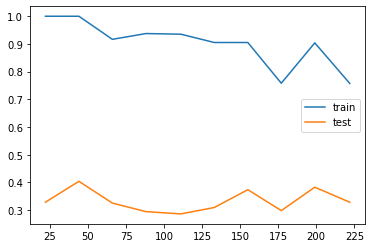

In [30]:
model_expand=make_pipeline(PolynomialFeatures(2), SelectKBest(f_classif,k=10),RandomForestClassifier(random_state=0))
evaluation (model_expand)

# MORE SYSTEMATIC : numerous modeles comparison

In [31]:
#one pipeline for each modele
pipeline_forest=make_pipeline(SelectKBest(f_classif,k=10),RandomForestClassifier(random_state=0))
pipeline_ada=make_pipeline(SelectKBest(f_classif,k=10),AdaBoostClassifier(random_state=0))

#with standard scaler
pipeline_KNN=make_pipeline(SelectKBest(f_classif,k=10),StandardScaler(),KNeighborsClassifier())
pipeline_LR=make_pipeline(SelectKBest(f_classif,k=10),StandardScaler(), LogisticRegression(random_state=0))
pipeline_SVM=make_pipeline(SelectKBest(f_classif,k=10),StandardScaler(), SVC(random_state=0))
pipeline_xgb=make_pipeline(SelectKBest(f_classif,k=10),StandardScaler(), xgb.XGBClassifier())


C:\Users\pierr\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:114: UserWarning: Features [21 26 32] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
C:\Users\pierr\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


score f1 0.5
[[54  0]
 [ 8  4]]
              precision    recall  f1-score   support

           0       0.87      1.00      0.93        54
           1       1.00      0.33      0.50        12

    accuracy                           0.88        66
   macro avg       0.94      0.67      0.72        66
weighted avg       0.89      0.88      0.85        66



C:\Users\pierr\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:114: UserWarning: Features [ 3 18 19 21 24 25 26 27 28 29 30 31 32 33] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
C:\Users\pierr\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\pierr\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:114: UserWarning: Features [19 21 24 26 27 28 29 32 33] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
C:\Users\pierr\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\pierr\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:114: UserWarning: Features [19 21 26 28 32 33] are constant.
  warnings.warn("Fea

C:\Users\pierr\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:114: UserWarning: Features [21 22 24 25 26 27 28 29 30 32 33] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
C:\Users\pierr\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\pierr\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:114: UserWarning: Features [21 24 25 26 27 28 29 30 32] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
C:\Users\pierr\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\pierr\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:114: UserWarning: Features [21 24 25 26 27 28 29 30 32] are constant.
  warnings.warn("Fea

score f1 0.47058823529411764
[[53  1]
 [ 8  4]]
              precision    recall  f1-score   support

           0       0.87      0.98      0.92        54
           1       0.80      0.33      0.47        12

    accuracy                           0.86        66
   macro avg       0.83      0.66      0.70        66
weighted avg       0.86      0.86      0.84        66



C:\Users\pierr\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:114: UserWarning: Features [ 3 18 19 21 24 25 26 27 28 29 30 31 32 33] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
C:\Users\pierr\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\pierr\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:114: UserWarning: Features [19 21 24 26 27 28 29 32 33] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
C:\Users\pierr\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\pierr\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:114: UserWarning: Features [19 21 26 28 32 33] are constant.
  warnings.warn("Fea

C:\Users\pierr\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:114: UserWarning: Features [21 24 25 26 27 28 29 30 32] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
C:\Users\pierr\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\pierr\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:114: UserWarning: Features [21 24 25 26 27 28 29 32] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
C:\Users\pierr\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\pierr\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:114: UserWarning: Features [21 24 26 28 32] are constant.
  warnings.warn("Features %s are constant

score f1 0.35294117647058826
[[52  2]
 [ 9  3]]
              precision    recall  f1-score   support

           0       0.85      0.96      0.90        54
           1       0.60      0.25      0.35        12

    accuracy                           0.83        66
   macro avg       0.73      0.61      0.63        66
weighted avg       0.81      0.83      0.80        66



C:\Users\pierr\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:114: UserWarning: Features [21 26 32] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
C:\Users\pierr\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\pierr\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:114: UserWarning: Features [21 26 32] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
C:\Users\pierr\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\pierr\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:114: UserWarning: Features [21 26 32] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
C:\Users\pi

C:\Users\pierr\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:114: UserWarning: Features [21 26 28 32] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
C:\Users\pierr\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\pierr\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:114: UserWarning: Features [21 26 28 32] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
C:\Users\pierr\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\pierr\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:114: UserWarning: Features [21 26 28 32] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
C:

score f1 0.5555555555555556
[[53  1]
 [ 7  5]]
              precision    recall  f1-score   support

           0       0.88      0.98      0.93        54
           1       0.83      0.42      0.56        12

    accuracy                           0.88        66
   macro avg       0.86      0.70      0.74        66
weighted avg       0.87      0.88      0.86        66



C:\Users\pierr\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:114: UserWarning: Features [19 21 24 26 27 28 29 32 33] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
C:\Users\pierr\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\pierr\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:114: UserWarning: Features [19 21 26 28 32 33] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
C:\Users\pierr\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\pierr\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:114: UserWarning: Features [19 21 26 28 32] are constant.
  warnings.warn("Features %s are constant." % c

C:\Users\pierr\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:114: UserWarning: Features [21 24 26 28 32] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
C:\Users\pierr\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\pierr\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:114: UserWarning: Features [21 26 28 32] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
C:\Users\pierr\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\pierr\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:114: UserWarning: Features [21 26 28 32] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,

score f1 0.4
[[54  0]
 [ 9  3]]
              precision    recall  f1-score   support

           0       0.86      1.00      0.92        54
           1       1.00      0.25      0.40        12

    accuracy                           0.86        66
   macro avg       0.93      0.62      0.66        66
weighted avg       0.88      0.86      0.83        66



C:\Users\pierr\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:114: UserWarning: Features [19 21 26 28 32] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
C:\Users\pierr\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\pierr\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:114: UserWarning: Features [21 26 32] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
C:\Users\pierr\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\pierr\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:114: UserWarning: Features [21 26 32] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
C:\Us

C:\Users\pierr\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:114: UserWarning: Features [21 26 28 32] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
C:\Users\pierr\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\pierr\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:114: UserWarning: Features [21 26 28 32] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
C:\Users\pierr\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\pierr\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:114: UserWarning: Features [ 3 21 22 24 25 26 27 28 29 30 32 33] are constant.
  warnings.warn("Features %s are constant." % c

[16:11:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
score f1 0.4
[[54  0]
 [ 9  3]]
              precision    recall  f1-score   support

           0       0.86      1.00      0.92        54
           1       1.00      0.25      0.40        12

    accuracy                           0.86        66
   macro avg       0.93      0.62      0.66        66
weighted avg       0.88      0.86      0.83        66

[16:11:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\pierr\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:114: UserWarning: Features [ 3 18 19 21 24 25 26 27 28 29 30 31 32 33] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
C:\Users\pierr\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\pierr\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\pierr\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:114: UserWarning: Features [19 21

[16:11:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:11:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:11:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\pierr\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:114: UserWarning: Features [19 21 26 28 32] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
C:\Users\pierr\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\pierr\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\pierr\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:114: UserWarning: Features [19 21 26 28 32] are constant.
  

[16:11:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:11:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\pierr\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:114: UserWarning: Features [21 26 32] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
C:\Users\pierr\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\pierr\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\pierr\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:114: UserWarning: Features [21 26 32] are constant.
  warnings.war

[16:11:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:11:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\pierr\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\pierr\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:114: UserWarning: Features [21 26 32] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
C:\Users\pierr\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\pierr\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a

[16:11:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:11:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:11:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\pierr\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\pierr\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:114: UserWarning: Features [21 22 24 25 26 27 28 29 30 32 33] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
C:\Users\pierr\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\pierr\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated 

[16:11:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:11:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:11:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\pierr\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:114: UserWarning: Features [21 24 25 26 27 28 29 30 32] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
C:\Users\pierr\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\pierr\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\pierr\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:114: UserWarning: Features [21 26 27 28 29 30 32

[16:11:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:11:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:11:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\pierr\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:114: UserWarning: Features [21 26 27 30 32] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
C:\Users\pierr\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\pierr\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\pierr\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:114: UserWarning: Features [21 26 27 30 32] are constant.
  

[16:11:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:11:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\pierr\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\pierr\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:114: UserWarning: Features [21 26 27 32] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
C:\Users\pierr\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\pierr\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed i

[16:11:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:11:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:11:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\pierr\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\pierr\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:114: UserWarning: Features [21 22 24 25 26 27 28 29 30 32 33] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
C:\Users\pierr\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\pierr\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated 

[16:11:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:11:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:11:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

C:\Users\pierr\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:114: UserWarning: Features [21 24 25 26 27 28 29 30 32] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
C:\Users\pierr\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\pierr\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\pierr\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:114: UserWarning: Features [21 24 25 26 27 28 29


[16:11:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:11:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\pierr\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:114: UserWarning: Features [21 26 28 32] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
C:\Users\pierr\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\pierr\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\pierr\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:114: UserWarning: Features [21 26 28 32] are constant.
  warnin

[16:11:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:11:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\pierr\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\pierr\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:114: UserWarning: Features [21 26 28 32] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
C:\Users\pierr\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\pierr\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed i

[16:11:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:11:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:11:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\pierr\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\pierr\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:114: UserWarning: Features [21 22 24 25 26 27 28 29 30 32 33] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
C:\Users\pierr\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\pierr\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated 

[16:11:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:11:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:11:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\pierr\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\pierr\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:114: UserWarning: Features [21 24 25 26 27 28 29 32] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
C:\Users\pierr\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\pierr\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will 

[16:11:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:11:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\pierr\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:114: UserWarning: Features [21 26 28 32] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
C:\Users\pierr\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\pierr\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\pierr\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:114: UserWarning: Features [21 26 28 32] are constant.
  warnin

[16:11:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:11:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\pierr\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:114: UserWarning: Features [21 26 32] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
C:\Users\pierr\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\pierr\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\pierr\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:114: UserWarning: Features [21 26 32] are constant.
  warnings.war

[16:11:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


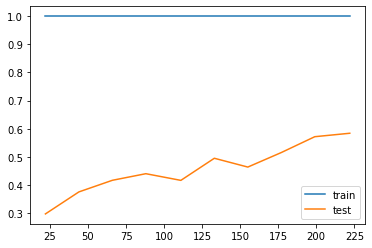

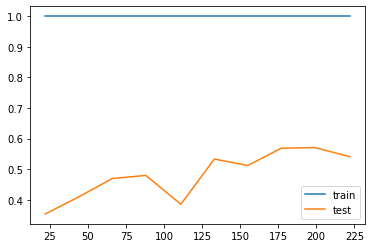

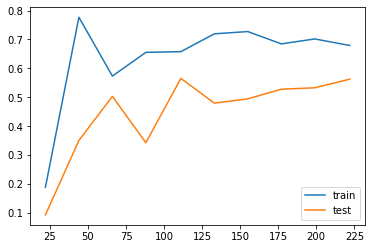

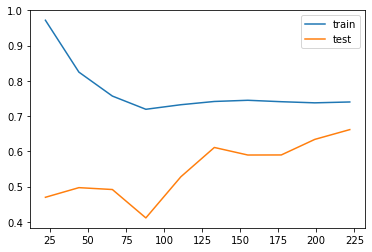

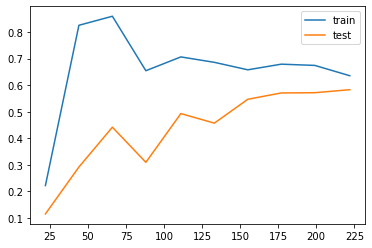

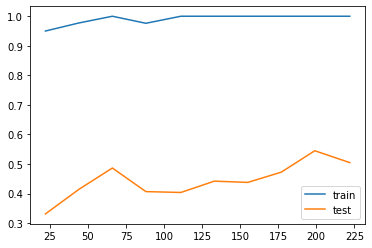

In [36]:
list_of_models=[pipeline_forest, pipeline_ada, pipeline_KNN, pipeline_LR, pipeline_SVM, pipeline_xgb] 

for model in list_of_models:
    evaluation(model) 

# Hyper parameters optimization with a gridsearch:

In [24]:
pipeline_LR # to see the differents steps of the pipeline

Pipeline(steps=[('selectkbest', SelectKBest()),
                ('standardscaler', StandardScaler()),
                ('logisticregression', LogisticRegression(random_state=0))])

C:\Users\pierr\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:114: UserWarning: Features [21 26 32] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
C:\Users\pierr\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\pierr\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:114: UserWarning: Features [21 26 27 32] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
C:\Users\pierr\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\pierr\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:114: UserWarning: Features [21 26 28 32] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
C:\Us

C:\Users\pierr\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:114: UserWarning: Features [21 26 32] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
C:\Users\pierr\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\pierr\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:114: UserWarning: Features [21 26 27 32] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
C:\Users\pierr\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\pierr\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:114: UserWarning: Features [21 26 28 32] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
C:\Us

C:\Users\pierr\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:114: UserWarning: Features [21 26 27 32] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
C:\Users\pierr\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\pierr\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:114: UserWarning: Features [21 26 28 32] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
C:\Users\pierr\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\pierr\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:114: UserWarning: Features [21 26 32] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
C:\Us

C:\Users\pierr\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:114: UserWarning: Features [21 26 32] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
C:\Users\pierr\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\pierr\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:114: UserWarning: Features [21 26 32] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
C:\Users\pierr\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\pierr\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:114: UserWarning: Features [21 26 27 32] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
C:\Users

{'logisticregression__C': 10, 'selectkbest__k': 20}
score f1 0.6
[[52  2]
 [ 6  6]]
              precision    recall  f1-score   support

           0       0.90      0.96      0.93        54
           1       0.75      0.50      0.60        12

    accuracy                           0.88        66
   macro avg       0.82      0.73      0.76        66
weighted avg       0.87      0.88      0.87        66



C:\Users\pierr\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:114: UserWarning: Features [19 21 26 28 32 33] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
C:\Users\pierr\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\pierr\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:114: UserWarning: Features [19 21 26 28 32] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
C:\Users\pierr\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\pierr\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:114: UserWarning: Features [19 21 26 28 32] are constant.
  warnings.warn("Features %s are constant." % constant_feat

C:\Users\pierr\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:114: UserWarning: Features [21 24 25 26 27 28 29 30 32] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
C:\Users\pierr\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\pierr\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:114: UserWarning: Features [21 24 25 26 27 28 29 32] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
C:\Users\pierr\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\pierr\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:114: UserWarning: Features [21 24 26 28 32] are constant.
  warnings.warn("Features %s are constant

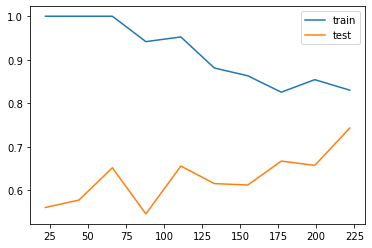

In [37]:
hyper_params={'logisticregression__C':[0.1, 1, 10 , 100],'selectkbest__k':[5, 6, 10, 20, 100]} # double underscore notation


grid=GridSearchCV(pipeline_LR,hyper_params,scoring='f1', cv=4)
grid.fit(X_train,y_train)

print(grid.best_params_)

best_modele=grid.best_estimator_
evaluation(best_modele)

# Faster : randomsearch CV

C:\Users\pierr\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:278: UserWarning: The total space of parameters 162 is smaller than n_iter=1000. Running 162 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
C:\Users\pierr\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:114: UserWarning: Features [21 26 32] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
C:\Users\pierr\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\pierr\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:114: UserWarning: Features [21 26 32] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
C:\Users\pierr\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide

C:\Users\pierr\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:114: UserWarning: Features [21 26 32] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
C:\Users\pierr\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\pierr\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:114: UserWarning: Features [21 26 32] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
C:\Users\pierr\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\pierr\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:114: UserWarning: Features [21 26 27 32] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
C:\Users

C:\Users\pierr\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:114: UserWarning: Features [21 26 32] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
C:\Users\pierr\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\pierr\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:114: UserWarning: Features [21 26 32] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
C:\Users\pierr\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\pierr\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:114: UserWarning: Features [21 26 27 32] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
C:\Users

C:\Users\pierr\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:114: UserWarning: Features [21 26 32] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
C:\Users\pierr\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\pierr\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:114: UserWarning: Features [21 26 32] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
C:\Users\pierr\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\pierr\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:114: UserWarning: Features [21 26 32] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
C:\Users\pi

C:\Users\pierr\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\pierr\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:114: UserWarning: Features [21 26 28 32] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
C:\Users\pierr\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\pierr\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:114: UserWarning: Features [21 26 32] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
C:\Users\pierr\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\pierr\anaconda3\lib\site-packages\sklearn\

C:\Users\pierr\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:114: UserWarning: Features [21 26 32] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
C:\Users\pierr\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\pierr\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:114: UserWarning: Features [21 26 27 32] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
C:\Users\pierr\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\pierr\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:114: UserWarning: Features [21 26 28 32] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
C:\Us

C:\Users\pierr\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:114: UserWarning: Features [21 26 32] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
C:\Users\pierr\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\pierr\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:114: UserWarning: Features [21 26 27 32] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
C:\Users\pierr\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\pierr\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:114: UserWarning: Features [21 26 28 32] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
C:\Us

C:\Users\pierr\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:114: UserWarning: Features [21 26 28 32] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
C:\Users\pierr\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\pierr\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:114: UserWarning: Features [21 26 32] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
C:\Users\pierr\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\pierr\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:114: UserWarning: Features [21 26 32] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
C:\Users

C:\Users\pierr\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:114: UserWarning: Features [21 26 32] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
C:\Users\pierr\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\pierr\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:114: UserWarning: Features [21 26 32] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
C:\Users\pierr\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\pierr\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:114: UserWarning: Features [21 26 27 32] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
C:\Users

C:\Users\pierr\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:114: UserWarning: Features [21 26 28 32] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
C:\Users\pierr\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\pierr\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:114: UserWarning: Features [21 26 32] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
C:\Users\pierr\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\pierr\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:114: UserWarning: Features [21 26 32] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
C:\Users

C:\Users\pierr\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:114: UserWarning: Features [21 26 32] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
C:\Users\pierr\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\pierr\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:114: UserWarning: Features [21 26 32] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
C:\Users\pierr\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\pierr\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:114: UserWarning: Features [21 26 27 32] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
C:\Users

C:\Users\pierr\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:114: UserWarning: Features [21 26 27 32] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
C:\Users\pierr\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\pierr\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:114: UserWarning: Features [21 26 28 32] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
C:\Users\pierr\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\pierr\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:114: UserWarning: Features [21 26 32] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
C:\Us

C:\Users\pierr\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:114: UserWarning: Features [21 26 27 32] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
C:\Users\pierr\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\pierr\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:114: UserWarning: Features [21 26 28 32] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
C:\Users\pierr\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\pierr\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:114: UserWarning: Features [21 26 32] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
C:\Us

C:\Users\pierr\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:114: UserWarning: Features [21 26 27 32] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
C:\Users\pierr\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\pierr\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:114: UserWarning: Features [21 26 28 32] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
C:\Users\pierr\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\pierr\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:114: UserWarning: Features [21 26 32] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
C:\Us

C:\Users\pierr\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:114: UserWarning: Features [21 26 32] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
C:\Users\pierr\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\pierr\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:114: UserWarning: Features [21 26 32] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
C:\Users\pierr\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\pierr\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:114: UserWarning: Features [21 26 27 32] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
C:\Users

C:\Users\pierr\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:114: UserWarning: Features [21 26 32] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
C:\Users\pierr\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\pierr\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:114: UserWarning: Features [21 26 27 32] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
C:\Users\pierr\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\pierr\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:114: UserWarning: Features [21 26 28 32] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
C:\Us

C:\Users\pierr\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:114: UserWarning: Features [21 26 32] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
C:\Users\pierr\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\pierr\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:114: UserWarning: Features [21 26 32] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
C:\Users\pierr\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\pierr\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:114: UserWarning: Features [21 26 32] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
C:\Users\pi

C:\Users\pierr\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:114: UserWarning: Features [21 26 27 32] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
C:\Users\pierr\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\pierr\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:114: UserWarning: Features [21 26 28 32] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
C:\Users\pierr\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\pierr\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:114: UserWarning: Features [21 26 32] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
C:\Us

C:\Users\pierr\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:114: UserWarning: Features [21 26 28 32] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
C:\Users\pierr\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\pierr\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:114: UserWarning: Features [21 26 32] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
C:\Users\pierr\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\pierr\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:114: UserWarning: Features [21 26 32] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
C:\Users

C:\Users\pierr\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:114: UserWarning: Features [21 26 28 32] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
C:\Users\pierr\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\pierr\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:114: UserWarning: Features [21 26 32] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
C:\Users\pierr\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\pierr\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:114: UserWarning: Features [21 26 32] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
C:\Users

C:\Users\pierr\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:114: UserWarning: Features [21 26 27 32] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
C:\Users\pierr\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\pierr\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:114: UserWarning: Features [21 26 28 32] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
C:\Users\pierr\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\pierr\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (

C:\Users\pierr\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:114: UserWarning: Features [21 26 27 32] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
C:\Users\pierr\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\pierr\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\pierr\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:11

C:\Users\pierr\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:114: UserWarning: Features [21 26 32] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
C:\Users\pierr\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\pierr\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\pierr\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:114: 

C:\Users\pierr\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:114: UserWarning: Features [21 26 27 32] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
C:\Users\pierr\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\pierr\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\pierr\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:11

C:\Users\pierr\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:114: UserWarning: Features [21 26 27 32] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
C:\Users\pierr\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\pierr\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\pierr\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:11

C:\Users\pierr\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:114: UserWarning: Features [21 26 32] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
C:\Users\pierr\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\pierr\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:114: UserWarning: Features [21 26 32] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
C:\Users\pierr\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\pierr\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:114: UserWarning: Features [21 26 27 32] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
C:\Users

C:\Users\pierr\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:114: UserWarning: Features [21 26 27 32] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
C:\Users\pierr\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\pierr\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:114: UserWarning: Features [21 26 28 32] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
C:\Users\pierr\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\pierr\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:114: UserWarning: Features [21 26 32] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
C:\Us

C:\Users\pierr\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:114: UserWarning: Features [21 26 27 32] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
C:\Users\pierr\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\pierr\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:114: UserWarning: Features [21 26 28 32] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
C:\Users\pierr\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\pierr\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:114: UserWarning: Features [21 26 32] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
C:\Us

C:\Users\pierr\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\pierr\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:114: UserWarning: Features [21 26 28 32] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
C:\Users\pierr\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\pierr\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:11

C:\Users\pierr\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\pierr\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:114: UserWarning: Features [21 26 32] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
C:\Users\pierr\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\pierr\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarnin

C:\Users\pierr\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\pierr\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:114: UserWarning: Features [21 26 32] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
C:\Users\pierr\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\pierr\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarnin

C:\Users\pierr\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\pierr\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:114: UserWarning: Features [21 26 32] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
C:\Users\pierr\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\pierr\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarnin

C:\Users\pierr\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\pierr\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:114: UserWarning: Features [21 26 27 32] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
C:\Users\pierr\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\pierr\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWar

C:\Users\pierr\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\pierr\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:114: UserWarning: Features [21 26 27 32] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
C:\Users\pierr\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\pierr\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWar

C:\Users\pierr\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\pierr\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:114: UserWarning: Features [21 26 27 32] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
C:\Users\pierr\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\pierr\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWar

C:\Users\pierr\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:114: UserWarning: Features [21 26 32] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
C:\Users\pierr\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\pierr\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:114: UserWarning: Features [21 26 32] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
C:\Users\pierr\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\pierr\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:114: UserWarning: Features [21 26 27 32] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
C:\Users

C:\Users\pierr\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:114: UserWarning: Features [21 26 32] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
C:\Users\pierr\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\pierr\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:114: UserWarning: Features [21 26 32] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
C:\Users\pierr\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\pierr\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:114: UserWarning: Features [21 26 32] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
C:\Users\pi

C:\Users\pierr\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:114: UserWarning: Features [21 26 28 32] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
C:\Users\pierr\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\pierr\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:114: UserWarning: Features [21 26 32] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
C:\Users\pierr\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\pierr\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:114: UserWarning: Features [21 26 32] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
C:\Users

C:\Users\pierr\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\pierr\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:114: UserWarning: Features [21 26 28 32] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
C:\Users\pierr\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\pierr\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWar

C:\Users\pierr\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:114: UserWarning: Features [21 26 32] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
C:\Users\pierr\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\pierr\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\pierr\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:114: 

C:\Users\pierr\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\pierr\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:114: UserWarning: Features [21 26 32] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
C:\Users\pierr\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\pierr\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarnin

C:\Users\pierr\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:114: UserWarning: Features [21 26 32] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
C:\Users\pierr\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\pierr\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\pierr\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:114: 

C:\Users\pierr\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:114: UserWarning: Features [21 26 27 32] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
C:\Users\pierr\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\pierr\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\pierr\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:11

C:\Users\pierr\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\pierr\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:114: UserWarning: Features [21 26 27 32] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
C:\Users\pierr\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\pierr\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWar

{'selectkbest__k': 25, 'logisticregression__C': 100}
score f1 0.6363636363636365
[[51  3]
 [ 5  7]]
              precision    recall  f1-score   support

           0       0.91      0.94      0.93        54
           1       0.70      0.58      0.64        12

    accuracy                           0.88        66
   macro avg       0.81      0.76      0.78        66
weighted avg       0.87      0.88      0.87        66



C:\Users\pierr\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:114: UserWarning: Features [19 21 26 28 32] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
C:\Users\pierr\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\pierr\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:114: UserWarning: Features [19 21 26 28 32] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
C:\Users\pierr\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\pierr\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterat

C:\Users\pierr\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:114: UserWarning: Features [21 26 27 30 32] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
C:\Users\pierr\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\pierr\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\pierr\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py

C:\Users\pierr\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:114: UserWarning: Features [21 24 25 26 27 28 29 32] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
C:\Users\pierr\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\pierr\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:114: UserWarning: Features [21 24 26 28 32] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
C:\Users\pierr\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\pierr\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number 

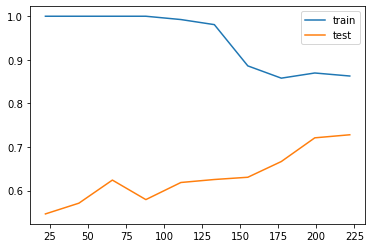

In [38]:
hyper_params={'logisticregression__C':[0.1, 1, 10 , 100, 1000, 10000],'selectkbest__k':range(3,30)}


grid=RandomizedSearchCV(pipeline_LR,hyper_params,scoring='f1', cv=5, n_iter=1000)
grid.fit(X_train,y_train)

print(grid.best_params_)

best_modele2=grid.best_estimator_
evaluation(best_modele2)

# Best threshold in order to have a good precision/recall balance.

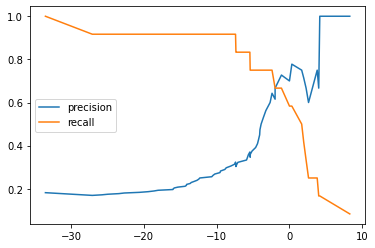

In [39]:
precision, recall, threshold = precision_recall_curve( y_test, best_modele2.decision_function(X_test))

plt.plot(threshold, precision[:-1], label='precision')
plt.plot(threshold, recall[:-1], label='recall')
plt.legend()

#remember precision is (TP/FP+TP) valeur predictive positive et recall is (TP/TP+FN) rappel

# Threshold choosen in order to get recall > 0.75.

In [42]:
def modele_final(modele, X_true, threshold_to_choose):
    boolean = modele.decision_function(X_true) > threshold_to_choose
    return boolean
    
ypred = modele_final(best_modele2, X_test, -3)

print(classification_report(y_test, ypred))
   

              precision    recall  f1-score   support

           0       0.94      0.89      0.91        54
           1       0.60      0.75      0.67        12

    accuracy                           0.86        66
   macro avg       0.77      0.82      0.79        66
weighted avg       0.88      0.86      0.87        66

